In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from scipy import stats
import sys
from pathlib import Path
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from rich.table import Table
from rich.console import Console
from rich.panel import Panel

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 150

def _resolve_project_root() -> Path:
    here = Path.cwd().resolve()
    for candidate in (here, *here.parents):
        if (candidate / 'config.py').exists():
            return candidate
    raise FileNotFoundError('config.py not found in cwd or parents')

PROJECT_ROOT = _resolve_project_root()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

print(f'project root: {PROJECT_ROOT}')

from config import (
    GENE_PATHS,
    VARIANT_PATHS,
    SOURCE_PALETTE,
    load_variant_pairs_matched,
)
from utils.plot_utils import autosave

print('\navailable datasets:')
for name in ['clingen', 'clingen_null', 'background', 'background_null']:
    print(f'  {name}: {VARIANT_PATHS[name].name}')

project root: /Users/markus/in-silico-vg-analysis

available datasets:
  clingen: ClinGen_HI_Gnomad_variants_dedup_27012026.parquet
  clingen_null: ClinGen_HI_Synth_variants_downsampled_perm_27012026.parquet
  background: Background_Gnomad_variants_dedup_perm_27012026.parquet
  background_null: Background_Synth_variants_downsampled_perm_27012026.parquet


In [2]:
CLINGEN_VAR = VARIANT_PATHS['clingen']
BG_VAR = VARIANT_PATHS['background']
BG_NULL_VAR = VARIANT_PATHS['background_null']
CLINGEN_NULL_VAR = VARIANT_PATHS['clingen_null']

CLINGEN_GENE = GENE_PATHS['clingen']
BG_GENE = GENE_PATHS['background']
BG_NULL_GENE = GENE_PATHS['background_null']
CLINGEN_NULL_GENE = GENE_PATHS['clingen_null']

PATHS = {
    'background': BG_VAR,
    'background_null': BG_NULL_VAR,
    'clingen': CLINGEN_VAR,
    'clingen_null': CLINGEN_NULL_VAR,
}

df = pl.read_parquet(BG_VAR)
print(df.columns)

['variant_id', 'scored_interval', 'gene_id', 'gene_name', 'gene_type', 'gene_strand', 'junction_Start', 'junction_End', 'output_type', 'variant_scorer', 'track_name', 'track_strand', 'Assay title', 'ontology_curie', 'biosample_name', 'biosample_type', 'gtex_tissue', 'raw_score', 'quantile_score', 'scored_interval_str', 'is_anchor', 'seq_len', 'scorer_friendly', 'gene_norm', 'CHROM', 'POS', 'REF', 'ALT', 'gene_tag', 'method_friendly', 'variant_id_canonical', 'CHROM_af', 'POS_af', 'REF_af', 'ALT_af', 'AF', 'perm_AF']


In [3]:
real_bg = pl.read_parquet(VARIANT_PATHS['background'])
null_bg = pl.read_parquet(VARIANT_PATHS['background_null'])
real_cg = pl.read_parquet(VARIANT_PATHS['clingen'])
null_cg = pl.read_parquet(VARIANT_PATHS['clingen_null'])

variant_tables = {
    'background': real_bg,
    'background_null': null_bg,
    'clingen': real_cg,
    'clingen_null': null_cg,
}

print("Loading and aligning gene metadata...")
gene_tables = {
    'background': pl.read_parquet(GENE_PATHS['background']),
    'background_null': pl.read_parquet(GENE_PATHS['background_null']),
    'clingen': pl.read_parquet(GENE_PATHS['clingen']),
    'clingen_null': pl.read_parquet(GENE_PATHS['clingen_null']),
}

for name in gene_tables:
    valid_genes = variant_tables[name]['gene_id'].unique().to_list()

    gene_tables[name] = gene_tables[name].filter(pl.col('gene_id').is_in(valid_genes))

    print(f"  {name}: aligned to {gene_tables[name].height} genes")

Loading and aligning gene metadata...
  background: aligned to 349 genes
  background_null: aligned to 349 genes
  clingen: aligned to 316 genes
  clingen_null: aligned to 316 genes


1999142
[save_plot] Saved: interactive_Variant_Score_Distribution_29012026_0923.pdf
[save_plot] Saved: interactive_Variant_Score_Distribution_29012026_0923.svg


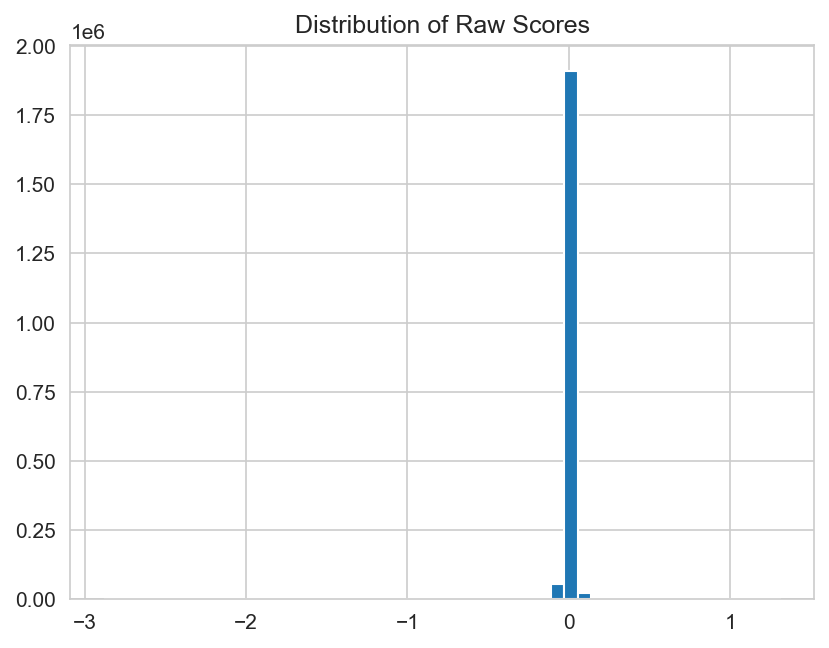

In [10]:
# Option A: Context Manager
with autosave("Variant_Score_Distribution"):
    plt.hist(df['raw_score'], bins=50)
    plt.title("Distribution of Raw Scores")
    print(df['raw_score'].count())

# Option B: Direct call
#fig, ax = plt.subplots()
#ax.scatter(x, y)
#save_plot(fig, title="Scatter_Analysis", outdir="./custom_output")